In [1]:
from lienp.modules.pointconv import PointConv
from lienp.liegroups import SO2

In [2]:
from lienp.datasets import RotationMNIST
from lienp.datasets import MetaImageDataset
import torchvision.transforms as tf
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from lienp.models import CNP
import torch

In [3]:
dataset = RotationMNIST('~/data/rotmnist', transform=tf.ToTensor())
# dataset = CIFAR10('/Users/makora/data/cifar10', transform=tf.ToTensor())

In [4]:
d = MetaImageDataset(dataset, train=False, max_total=500)

In [5]:
d

MetaImageDataset:
Dataset RotationMNIST
    Number of datapoints: 12000
    Root location: /Users/makora/data/rotmnist
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
iterdl = iter(DataLoader(d, batch_size=4, shuffle=False))

In [7]:
def mnist_plot_function(target_x, target_y, context_x, context_y):
    img = torch.zeros((28, 28, 3))
    img[:, :, 2] = torch.ones((28, 28))
    idx = (context_x + 14).clamp(0, 27).long()
    img[idx[:, 0], idx[:, 1]] = context_y
    print(img[idx[:, 0], idx[:, 1]].shape)
    print(context_y.shape)
    print(f'num context:{context_x.shape[0]}')
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.imshow(img.numpy())
    plt.gray()
    plt.subplot(122)
    plt.imshow(target_y.reshape(28, 28).numpy())
    plt.show()

torch.Size([410, 3])
torch.Size([410, 1])
num context:410


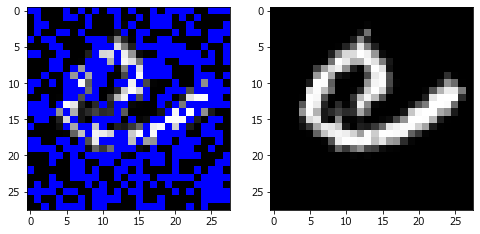

In [8]:
c, t = iterdl.next()
mnist_plot_function(t[0][0], t[1][0], c[0][0], c[1][0])

In [9]:
img = t[1].reshape(4, 1, 28, 28)

In [10]:
import math
angles = torch.rand(4) * 2 * math.pi

In [11]:
angles

tensor([0.5328, 3.8418, 5.4154, 0.9630])

In [12]:
affineMatrices = torch.zeros(4, 2, 3)
affineMatrices[:,0,0] = angles.cos()
affineMatrices[:,1,1] = angles.cos()
affineMatrices[:,0,1] = angles.sin()
affineMatrices[:,1,0] = -angles.sin()
max_trans = 0
affineMatrices[:,0,2] = (2*torch.rand(4)-1)*max_trans/28
affineMatrices[:,1,2] = (2*torch.rand(4)-1)*max_trans/28

In [13]:
affineMatrices

tensor([[[ 0.8614,  0.5079,  0.0000],
         [-0.5079,  0.8614,  0.0000]],

        [[-0.7647, -0.6444, -0.0000],
         [ 0.6444, -0.7647,  0.0000]],

        [[ 0.6466, -0.7629,  0.0000],
         [ 0.7629,  0.6466,  0.0000]],

        [[ 0.5710,  0.8209, -0.0000],
         [-0.8209,  0.5710, -0.0000]]])

In [14]:
from torchvision.transforms import ToPILImage
from lienp.transforms import RandomRotation

In [15]:
RandomRotation(3)

RandomRotation(degrees=(-3, 3), resample=False, expand=False)

In [16]:
dataset = RotationMNIST('~/data/rotmnist', transform=tf.Compose([RandomRotation(degrees=180), tf.ToTensor()]))

In [17]:
aug= False
[RandomRotation(180) if aug else None,
 tf.ToTensor()]

[None, ToTensor()]

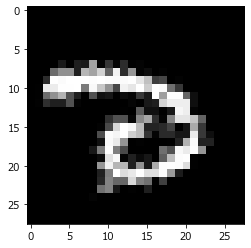

In [18]:
plt.imshow(dataset[0][0].reshape(28, 28))

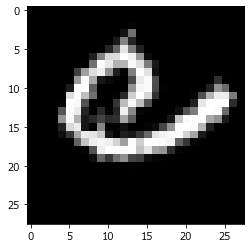

In [19]:
dataset = RotationMNIST('~/data/rotmnist', transform=tf.Compose([tf.ToTensor()]))
plt.imshow(dataset[0][0].reshape(28, 28))

In [20]:
from lienp.modules.pointconv import WeightNet

# PointConvの範囲可視化

In [21]:
from lienp.modules.pointconv import PointConv

In [22]:
pc = PointConv(1, 3, coords_dim=2, sampling_fraction=1, use_bn=True)

In [23]:
from lienp.utils import index_points, knn_points
from lienp.modules.euclid_farthersubsample import _farthest_point_sample
idx = _farthest_point_sample(t[0], 1, pc.subsample.distance)
if len(t) == 2:
    t.append(torch.ones(t[0].shape[:2]).bool())
query_coords = index_points(t[0], idx)
query_values = index_points(t[1], idx)
query_mask = index_points(t[2], idx)

nbhd_idx = knn_points(81, t[0][:,:,:None], query_coords[:,:,:None], t[2])
nbhd_coords = index_points(t[0], nbhd_idx)
nbhd_values = index_points(t[1], nbhd_idx)
nbhd_mask = index_points(t[2], nbhd_idx)

coords_deltas = pc.get_embedded_group_elements(query_coords.unsqueeze(2), nbhd_coords)
convolved_values = pc.point_conv(coords_deltas, nbhd_values, nbhd_mask)

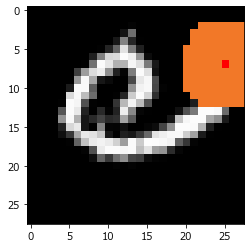

In [24]:
img = t[1][0].reshape(28, 28, 1).repeat(1, 1, 3)
plt.imshow(img)
# img[idx[0]//28, idx[0]%28, 0] = torch.ones(1)
# img[idx[0]//28, idx[0]%28, 1:] = torch.zeros(2)
tmp_idx = nbhd_idx[0].reshape(-1)
img[tmp_idx//28, tmp_idx%28] = torch.tensor([242/255, 120/255, 40/255])
img[idx[0]//28, idx[0]%28] = torch.tensor([1.0, 0, 0])
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


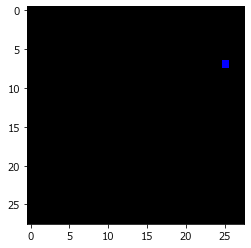

In [25]:
fm = torch.zeros(28, 28, 3)
fm[idx[0]//28, idx[0]%28] = convolved_values[0].detach()
plt.imshow(fm)

# PointConvの可視化

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


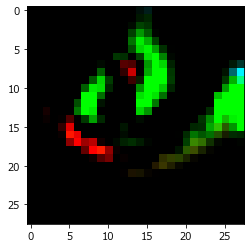

In [26]:
pcnn = PointConv(1, 3, coords_dim=2, sampling_fraction=1., num_nbhd=25, use_bn=True, mean=False)
plt.imshow(pcnn(t)[1][0].reshape(28, 28, 3).detach())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


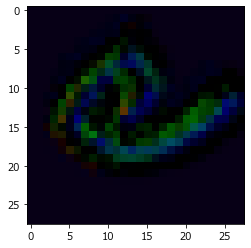

In [27]:
from torch import nn
cnn = nn.Conv2d(1, 3, 5, 1, 2, padding_mode='reflect')
plt.imshow(cnn(t[1][0].reshape(1, 1, 28, 28)).reshape(-1, 28, 28).detach().permute(1, 2, 0))

In [28]:
from lienp.models import PointCNP

In [29]:
model = PointCNP(2, 1)

In [30]:
a = model(c, t[0])

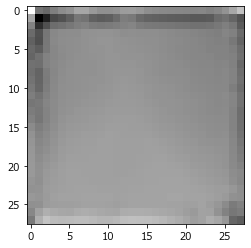

In [31]:
plt.imshow(a[0][0].reshape(28, 28).detach())


# LieConvの範囲可視化

In [85]:
from lienp.liegroups import *
from lienp.models import LieCNP
from lienp.modules import LieConv
from lienp.modules.group_farthersubsample import GroupFartherSubsample
from torchvision.transforms import Pad, ToTensor, ToPILImage

In [81]:
r = 2
group = T(2)
lifted_inputs = group.lift(t, 1)
B = torch.arange(4).long()[:, None]


In [82]:
idx = GroupFartherSubsample( 0.01/8, group=group)(lifted_inputs, withquery=True)[3]
ab_at_query = lifted_inputs[0][B, idx]
mask_at_query = lifted_inputs[2][B, idx]
dist_matrix = group.distance(ab_at_query)
dist_matrix= torch.where(lifted_inputs[2][:, None, :], dist_matrix, 1e8 * torch.ones_like(dist_matrix))

In [83]:
print(r)
within_ball = (dist_matrix < r) & lifted_inputs[2][:, None, :] & mask_at_query[:, :, None]
r += 1./20 - within_ball.float().sum(-1).sum() / mask_at_query[:, :, None].sum() /  lifted_inputs[2].sum(-1).float().mean()
nbhd_idx = torch.topk(within_ball + torch.zeros_like(dist_matrix).uniform_(0, 1), 81, dim=-1, largest=True, sorted=False)[1]

2


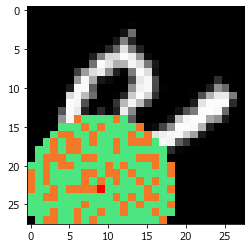

In [109]:
img = t[1][0].reshape(28, 28, 1).repeat(1, 1, 3)
plt.imshow(img)
img[within_ball[0, 0].reshape(28, 28)] = torch.tensor([0.3, 0.9, 0.5])
# img[idx[0]//28, idx[0]%28, 0] = torch.ones(1)
# img[idx[0]//28, idx[0]%28, 1:] = torch.zeros(2)
tmp_idx = nbhd_idx[0].reshape(-1)
img[tmp_idx//28, tmp_idx%28] = torch.tensor([242/255, 120/255, 40/255])
img[idx[0]//28, idx[0]%28] = torch.tensor([1.0, 0, 0])
plt.imshow(img)

In [37]:
x = torch.stack([dataset[0][0], dataset[1][0]], 0)

In [38]:
from lienp.models.convcnp import GridConvCNP

In [39]:
cnn = GridConvCNP(1)

In [40]:
from gpytorch.distributions import MultivariateNormal

In [41]:
m,s,mask = cnn(x)

In [42]:
mask.shape

torch.Size([2, 1, 28, 28])

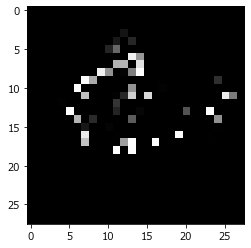

In [43]:
plt.imshow(mask[0,0] * x[0, 0])

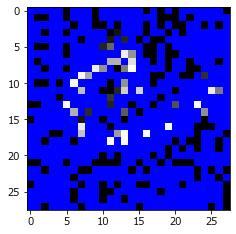

In [44]:
tmp = torch.zeros((28, 28, 3))
tmp[:, :, 2] = torch.ones((28, 28))
tmp[mask[0, 0] == 1] = x[0, 0][mask[0, 0] == 1].unsqueeze(-1)
# img[idx[:, 0], idx[:, 1]] = context_y
# print(img[idx[:, 0], idx[:, 1]].shape)
# print(context_y.shape)
# print(f'num context:{context_x.shape[0]}')
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(tmp.numpy())
plt.gray()
# plt.subplot(122)
# plt.imshow(target_y.reshape(28, 28).numpy())
# plt.show()

In [45]:
tmp[mask[0, 0] == 1]

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.1530e-03, 2.1530e-03, 2.1530e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0

In [46]:
x[0, 0][mask[0, 0] == 1]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.1530e-03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 3.3590e-03, 8.0499e-02, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 9.7292e-02, 1.4974e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4251e-01, 3.9968e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.3535e-01, 5.8385e-01,
        3.7000e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.9101e-01,
        7.0215e-01, 8.7496e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.5000e-05, 9.3253e-01, 5.6472e-01, 1.8403e-02, 4.9355e-01,
        9.8511e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.7935e-01, 6.6465e-01,
        2.9400e-04, 0.0000e+00, 0.0000e+

In [47]:
from lienp.models.liecnp import GridLieCNP

In [48]:
gcnp = GridLieCNP()

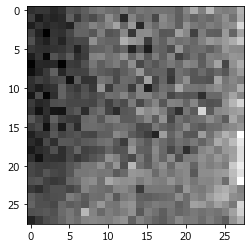

In [49]:
plt.imshow(gcnp(x)[0][0].detach().reshape(28, 28))

In [50]:
gcnp

GridLieCNP(
  (conv_theta): LieConv(
    C_in=1, C_out=128, C_mid=16, coords_dim=2, nbhd=81, sampling_fraction=1.0, mean=True
    fill=0.013, r=1.757
    (subsample): GroupFartherSubsample(group=T(0.2))
    (weightnet): WeightNet(in_features=2, out_features=16, hidden_features=32, bn=True)
    (linear): Linear(in_features=16, out_features=128, bias=True)
  )
  (cnn): Sequential(
    (0): Apply(
      dim=1
      (module): Linear(in_features=256, out_features=128, bias=True)
    )
    (1): ResBlock(
      (conv): Sequential(
        (0): SeparableLieConv(
          (depthwise): DepthwiseLieConv(
            C_in=128, C_out=128, C_mid=128, coords_dim=2, nbhd=25, sampling_fraction=1.0, mean=True
            fill=0.040, r=1.884
            (subsample): GroupFartherSubsample(group=T(0.2))
            (weightnet): WeightNet(in_features=2, out_features=128, hidden_features=32, bn=True)
            (linear): None
          )
          (pointwise): Linear(in_features=128, out_features=128, bias

In [51]:
GridLieCNP(group=SO2(0.2))

GridLieCNP(
  (conv_theta): LieConv(
    C_in=1, C_out=128, C_mid=16, coords_dim=3, nbhd=81, sampling_fraction=1.0, mean=True
    fill=0.013, r=2.000
    (subsample): GroupFartherSubsample(group=SO2(0.2))
    (weightnet): WeightNet(in_features=3, out_features=16, hidden_features=32, bn=True)
    (linear): Linear(in_features=16, out_features=128, bias=True)
  )
  (cnn): Sequential(
    (0): Apply(
      dim=1
      (module): Linear(in_features=256, out_features=128, bias=True)
    )
    (1): ResBlock(
      (conv): Sequential(
        (0): SeparableLieConv(
          (depthwise): DepthwiseLieConv(
            C_in=128, C_out=128, C_mid=128, coords_dim=3, nbhd=25, sampling_fraction=1.0, mean=True
            fill=0.040, r=2.000
            (subsample): GroupFartherSubsample(group=SO2(0.2))
            (weightnet): WeightNet(in_features=3, out_features=128, hidden_features=32, bn=True)
            (linear): None
          )
          (pointwise): Linear(in_features=128, out_features=128, 